In [1]:
import argparse
import csv
import re
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

import utils

from matplotlib.animation import FuncAnimation
from matplotlib.axes import Axes

def parse_trace(trace_file_name: str) -> pl.DataFrame:
    """
    # parse_trace

    Parse a trace file and return a polars DataFrame.

        Parameters:
            trace_file_name (str): The name of the trace file.

        Returns:
            polars.DataFrame: The parsed trace.

    Format of the trace file:
        (line number as index) gap ddl size prio

        Example:
            ```
            0.1 200 1300 1
            0.1 200 1300 2
    """
    trace = []
    with open(trace_file_name, "r") as f:
        lines = f.readlines()
        for idx, line in enumerate(lines):
            info = re.split(r"\s+", line)
            trace.append(
                {
                    "id": idx,
                    "start": float(info[0]),
                    "gap": float(info[0]),
                    "ddl": int(info[1]),
                    "size": int(info[2]),
                    "prio": int(info[3]),
                }
            )
    trace = pl.from_dicts(trace)
    trace["start"] = trace["start"].cumsum()
    return trace

def parse_server_log(server_log_file_name: str) -> pl.DataFrame:
    """
    # parse_server_log

    Parse a server log file and return a polars DataFrame.

        Parameters:
            server_log_file_name (str): The name of the server log file.

        Returns:
            polars.DataFrame: The parsed server log.

    Format of the server log file:
        CSV file with following columns:
        - block_id
        - start
        - complete
        - cancelled
        - cancelled_passed
    """
    try:
        server_log = pl.read_csv(server_log_file_name)
        server_log["block_id"] = server_log["block_id"].apply(lambda x: (x >> 2) - 1)
        return server_log
    except:
        return pl.DataFrame(
            None, ["block_id", "start", "complete", "cancelled", "cancelled_passed"]
        )

def parse_result(result_file_name: str) -> pl.DataFrame:
    """
    # parse_result

    Parse a result file and return a polars DataFrame.

        Parameters:
            result_file_name (str): The name of the result file.

        Returns:
            polars.DataFrame: The parsed result.

    Format of the result file:
        CSV file with following columns:
        - block_id
        - bct
        - size
        - priority
        - deadline
        - duration
    """
    try:
        result = pl.read_csv(result_file_name)
        result["block_id"] = result["block_id"].apply(lambda x: (x >> 2) - 1)
        return result
    except:
        return pl.DataFrame(
            None, ["block_id", "bct", "size", "priority", "deadline", "duration"]
        )
        
def find_unsend(result_file_name, trace_file_name):
    if trace_file_name is not None:
        block_num = utils.count_newlines(trace_file_name)
        trace = set(range(block_num))

        with open(result_file_name, "r") as f:
            reader = csv.DictReader(f)
            result = [((int(row["block_id"]) - 1) >> 2) - 1 for row in reader]

        res = sorted([(x, ((x + 1) << 2) + 1) for x in trace - set(result)])

        return (len(res), res)
    else:
        raise Exception("trace_file_name is None")


def total_time(trace_file_name):
    with open(trace_file_name, "r") as f:
        reader = csv.reader(f, delimiter=" ")
        return sum([float(row[0]) for row in reader])


def draw(result_file_name, trace_file_name):
    result = pl.read_csv(result_file_name)
    result["block_id"] = result["block_id"].apply(lambda x: (x >> 2) - 1)
    trace = parse_trace(trace_file_name).rename({"gap": "start"})
    trace["start"] = trace["start"].cumsum()
    result = result.join(trace, left_on="block_id", right_on="id", how="outer")
    print(result)
    result = result.select(
        [
            "block_id",
            (pl.col("bct") / 1000 < pl.col("ddl")).alias("intime"),
            # (
            #     (pl.col("duration") / 1000) < (pl.col("ddl") + pl.col("start") * 1000)
            # ).alias("intime"),
            "prio",
            "ddl",
            (pl.col("ddl") / 1e3 + pl.col("start")).alias("timestamp"),
        ]
    )
    print(result)

    x = result["timestamp"].to_numpy()
    y = np.zeros((8, len(x)))
    y_count = np.zeros(8)
    y_intime = np.zeros(8)
    for i in range(len(x)):
        y_count[result["prio"][i]] += 1
        if result["intime"][i]:
            y_intime[result["prio"][i]] += 1
        for j in range(8):
            y[j][i] = y_intime[j] / y_count[j] if y_count[j] > 0 else 1

    fig, ax = plt.subplots()
    # ax.plot(x, y[0], label="prio 0")
    ax.plot(x, y[1], label="prio 1")
    ax.plot(x, y[2], label="prio 2")
    # ax.plot(x, y[3], label="prio 3")
    # ax.plot(x, y[4], label="prio 4")
    # ax.plot(x, y[5], label="prio 5")
    # ax.plot(x, y[6], label="prio 6")
    # ax.plot(x, y[7], label="prio 7")

    ax.set_ylim(0, 1.05)
    ax.set_xlabel("time (s)")
    ax.set_ylabel("average intime ratio")
    ax.legend()

    plt.savefig(f"{os.path.basename(result_file_name).split('.')[0]}.png")

    result = result.groupby("prio").agg([pl.count(), (pl.col("intime") == True).sum()])
    print(result)

def hist(result_file_name, trace_file_name):
    trace = parse_trace(trace_file_name)
    # print(
    #     trace.groupby("prio").agg(
    #         [
    #             pl.count(),
    #             pl.mean("size").alias("size_mean"),
    #             pl.var("size").alias("size_var"),
    #         ]
    #     )
    # )
    # trace = trace.partition_by("prio")
    # prio_1 = trace[0]["size"].to_numpy()
    # prio_2 = trace[1]["size"].to_numpy()

    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("size (bytes)")
    # ax.set_ylabel("density")
    # trace = trace["size"].to_numpy()
    # fig, ax = plt.subplots()
    # # ax.plot(trace)
    # ax.scatter(np.arange(len(trace)), trace)
    # plt.savefig("trace_size.png")

    # result = pl.read_csv(result_file_name)
    # print(
    #     result.groupby("priority").agg(
    #         [
    #             pl.count(),
    #             pl.mean("bct").alias("bct_mean"),
    #             pl.var("bct").alias("bct_var"),
    #         ]
    #     )
    # )
    # result = result.partition_by("priority")
    # prio_1 = result[0]["bct"].to_numpy()
    # prio_2 = result[1]["bct"].to_numpy()
    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("bct (us)")
    # ax.set_ylabel("density")
    # plt.savefig("result_bct_hist.png")

In [2]:
for style in plt.style.available:
    print(style)

Solarize_Light2
_classic_test_patch
_mpl-gallery
_mpl-gallery-nogrid
bmh
classic
dark_background
fast
fivethirtyeight
ggplot
grayscale
seaborn
seaborn-bright
seaborn-colorblind
seaborn-dark
seaborn-dark-palette
seaborn-darkgrid
seaborn-deep
seaborn-muted
seaborn-notebook
seaborn-paper
seaborn-pastel
seaborn-poster
seaborn-talk
seaborn-ticks
seaborn-white
seaborn-whitegrid
tableau-colorblind10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


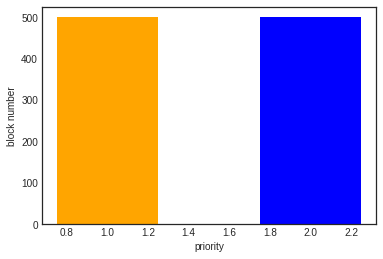

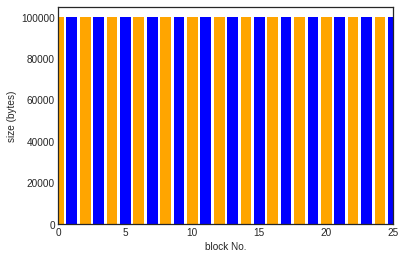

In [3]:
plt.style.use("seaborn-white")
def trace_hist(result_file_name, trace_file_name):
    trace = parse_trace(trace_file_name)
    # print the distribution of block_size, ddl and priority with block num
    # print(
    #     trace.groupby("prio").agg(
    #         [
    #             pl.count(),
    #             pl.mean("size").alias("size_mean"),
    #             pl.var("size").alias("size_var"),
    #         ]
    #     )
    # )
    prio_trace = trace.partition_by("prio")
    prio_1 = prio_trace[0]["size"].to_numpy()
    prio_2 = prio_trace[1]["size"].to_numpy()

    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("size (bytes)")
    # ax.set_ylabel("density")

    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("size (bytes)")
    # ax.set_ylabel("density")

    # block size trend with block num
    size_trace = trace["size"].to_numpy()
    fig, ax = plt.subplots()
    ax.bar([1, 2], [len(prio_trace[0]["prio"]), len(prio_trace[1]["prio"])], color=["orange", "blue"], width=0.5)
    ax.set_xlabel("priority")
    ax.set_ylabel("block number")
    ax.legend()

    # distribution of trace
    fig, ax = plt.subplots()
    size = 28
    # ax.scatter(np.arange(len(trace[:size])), size_trace[:size], c=["orange" if trace[i]["prio"][0] == 1 else "blue" for i in range(len(size_trace[:size]))])
    ax.bar(np.arange(len(trace[:size])), size_trace[:size], color=["orange" if trace[i]["prio"][0] == 1 else "blue" for i in range(len(size_trace[:size]))]) 
    ax.set_xlabel("block No.")
    ax.set_ylabel("size (bytes)")
    ax.set_xlim((0, 25))
    ax.legend()
    # ax.plot(size_trace)
    # ax.scatter(prio_trace[0]["id"].to_numpy(), prio_trace[0]["size"].to_numpy(), c=["red"])
    # ax.scatter(prio_trace[1]["id"].to_numpy(), prio_trace[1]["size"].to_numpy(), c=["yellow"])
    # plt.savefig("trace_size.png")

    # result = pl.read_csv(result_file_name)
    # print(
    #     result.groupby("priority").agg(
    #         [
    #             pl.count(),
    #             pl.mean("bct").alias("bct_mean"),
    #             pl.var("bct").alias("bct_var"),
    #         ]
    #     )
    # )
    # result = result.partition_by("priority")
    # prio_1 = result[0]["bct"].to_numpy()
    # prio_2 = result[1]["bct"].to_numpy()
    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("bct (us)")
    # ax.set_ylabel("density")
    # plt.savefig("result_bct_hist.png")
trace_hist("data/client_n_n.csv", "data/trace_1300_1ms_1000_seq012.txt")

In [4]:
# good put and avg bct
def get_stats(result_file_path):
    print("stats of %s" % result_file_path)
    result = parse_result(result_file_path)
    in_time = result.filter(pl.col("bct") <= pl.col("deadline"))
    good_bytes = np.sum(in_time["size"].to_numpy())
    total_bytes = np.sum(result["size"].to_numpy())
    finish_time = result["duration"][-1] # micro
    throughput = total_bytes * 8 / finish_time # Mbps
    goodput = good_bytes * 8 / finish_time # Mbps
    avg_bct = np.average(result["bct"].to_numpy()) #ms

    prio_result = result.partition_by("priority")
    for idx, prio_frame in enumerate(prio_result):
        avg_prio_bct = np.average(prio_frame["bct"].to_numpy()) #ms
        print("prio ", prio_frame["priority"][0], avg_prio_bct)
    print("throughput:", throughput)
    print("goodput: ", goodput)
    print("avg_bct: ", avg_bct)

get_stats("data/client_n_n_fifo.csv")
get_stats("data/client_n_n.csv")
get_stats("data/client_n_t_fifo.csv")
get_stats("data/client_n_t.csv")
get_stats("data/client_t_n_fifo.csv")
get_stats("data/client_t_n.csv")
get_stats("data/client_t_t_fifo.csv")
get_stats("data/client_t_t.csv")

stats of data/client_n_n_fifo.csv
prio  2 6253.49
prio  1 6272.96
throughput: 79.15136283311222
goodput:  24.141165664099226
avg_bct:  6263.225
stats of data/client_n_n.csv
prio  2 4487.272727272727
prio  1 2495.497142857143
throughput: 37.23159170075378
goodput:  37.07710376838551
avg_bct:  3040.9626556016597
stats of data/client_n_t_fifo.csv
prio  2 6235.638
prio  1 6556.792
throughput: 73.79030253378373
goodput:  23.243945298141877
avg_bct:  6396.215
stats of data/client_n_t.csv
prio  2 4511.716666666666
prio  1 2571.75625
throughput: 33.98894664005744
goodput:  33.83445142805718
avg_bct:  3100.836363636364
stats of data/client_t_n_fifo.csv
prio  2 6785.242
prio  1 6654.048
throughput: 70.32124414454778
goodput:  20.533803290207953
avg_bct:  6719.645
stats of data/client_t_n.csv
prio  2 4505.842857142857
prio  1 2519.5057471264367
throughput: 37.55173463235659
goodput:  37.24393352881268
avg_bct:  3089.3565573770493
stats of data/client_t_t_fifo.csv
prio  1 3468.5
prio  2 3425.816
t

In [19]:
def draw_in_time_rate(result_file_path1, result_file_path2, trace_file_path, label1="QUIC", label2="DTP"):
    trace = parse_trace(trace_file_path)
    trace_prio1, trace_prio2 = trace.partition_by("prio")
    trace_size = len(trace)
    result1_bcr = []
    result2_bcr = []
    for result_file_path in [result_file_path1, result_file_path2]:
        result = parse_result(result_file_path)
        result_prio2, result_prio1 = result.partition_by("priority")
        if result_file_path1 == result_file_path:
            result_bcr = result1_bcr
        else:
            result_bcr = result2_bcr
        # total_bcr = len(result.filter(pl.col("bct") <= pl.col("deadline"))) / trace_size
        prio1_bcr = len(result_prio1.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prio1)
        prio2_bcr = len(result_prio2.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prio2)
        # result_bcr.append(total_bcr)
        result_bcr.append(prio1_bcr)
        result_bcr.append(prio2_bcr)

    labels = ["High Priority", "Low Priority"]
    # quic_bcr = [len(results[0].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    # dtp_bcr = [len(results[1].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    x = np.arange(len(labels))  # the label locations
    width = 0.30  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, result1_bcr, width, label=label1)
    rects2 = ax.bar(x + width/2, result2_bcr, width, label=label2)
    ax.set_ylabel('Block Completion Rate')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

def draw_avg_bct(result_file_path1, result_file_path2, trace_file_path, label1="QUIC", label2="DTP"):
    trace = parse_trace(trace_file_path)
    trace_prio1, trace_prio2 = trace.partition_by("prio")
    trace_size = len(trace)
    result1_bct = []
    result2_bct = []
    for result_file_path in [result_file_path1, result_file_path2]:
        result = parse_result(result_file_path)
        result_prio2, result_prio1 = result.partition_by("priority")
        if result_file_path1 == result_file_path:
            result_bcr = result1_bct
        else:
            result_bcr = result2_bct
        # total_bct = np.average(result["bct"].to_numpy())
        prio1_bct = np.average(result_prio1["bct"].to_numpy())
        prio2_bct = np.average(result_prio2["bct"].to_numpy())
        # result_bcr.append(total_bct)
        result_bcr.append(prio1_bct)
        result_bcr.append(prio2_bct)

    labels = ["High Priority", "Low Priority"]
    # quic_bcr = [len(results[0].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    # dtp_bcr = [len(results[1].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    x = np.arange(len(labels))  # the label locations
    width = 0.30  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, result1_bct, width, label=label1)
    rects2 = ax.bar(x + width/2, result2_bct, width, label=label2)
    ax.set_ylabel('Average BCT')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

def draw_cmp_fig(result_file_paths=[], trace_file_path="", labels=[], width=0.2):
    if not trace_file_path:
        print("no trace file path")
        return
    while len(labels) < len(result_file_paths):
        labels.append("#" + str(len(labels)))
    trace = parse_trace(trace_file_path)
    trace_prio1, trace_prio2 = trace.partition_by("prio")
    trace_size = len(trace)
    bcrs = [[] for r in result_file_paths]
    bcts = [[] for r in result_file_paths]

    for idx, result_file_path in enumerate(result_file_paths):
        result = parse_result(result_file_path)
        result_prio2, result_prio1 = result.partition_by("priority")
        if result_prio1[0]["priority"][0] != 1:
            tmp = result_prio1
            result_prio1 = result_prio2
            result_prio2 = tmp
        
        result_bcr = bcrs[idx]
        total_bcr = len(result.filter(pl.col("bct") <= pl.col("deadline"))) / trace_size
        prio1_bcr = len(result_prio1.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prio1)
        prio2_bcr = len(result_prio2.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prio2)
        result_bcr.append(total_bcr)
        result_bcr.append(prio1_bcr)
        result_bcr.append(prio2_bcr)

        result_bct = bcts[idx]
        total_bct = np.average(result["bct"].to_numpy())
        prio1_bct = np.average(result_prio1["bct"].to_numpy())
        prio2_bct = np.average(result_prio2["bct"].to_numpy())
        result_bct.append(total_bct)
        result_bct.append(prio1_bct)
        result_bct.append(prio2_bct)
    
    x_labels = ["Total", "High Priority", "Low Priority"]
    x = np.arange(len(x_labels))  # the label locations
    fig, ax = plt.subplots()
    for idx, bcr in enumerate(bcrs):
        ax.bar(x + width * (idx - len(bcrs) // 2), bcr, width, label=labels[idx])
    ax.set_ylabel('Block Completion Rate')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()

    x = np.arange(len(x_labels))  # the label locations
    fig, ax = plt.subplots()
    for idx, bct in enumerate(bcts):
        ax.bar(x + width * (idx - len(bcts) // 2), bct, width, label=labels[idx])
    ax.set_ylabel('Average BCT')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()

stats of data/client_n_n_fifo.csv
prio  2 6253.49
prio  1 6272.96
throughput: 79.15136283311222
goodput:  24.141165664099226
avg_bct:  6263.225
stats of data/client_n_n.csv
prio  2 4487.272727272727
prio  1 2495.497142857143
throughput: 37.23159170075378
goodput:  37.07710376838551
avg_bct:  3040.9626556016597


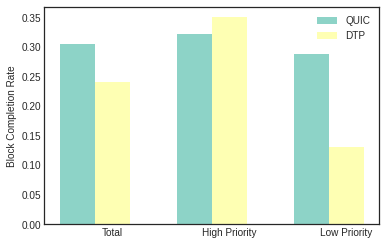

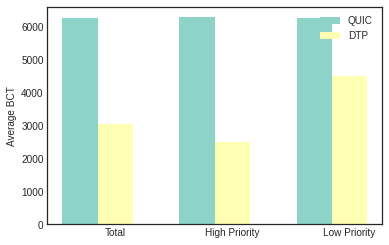

In [15]:
get_stats("data/client_n_n_fifo.csv")
get_stats("data/client_n_n.csv")
draw_cmp_fig(["data/client_n_n_fifo.csv", "data/client_n_n.csv"], "data/trace_1300_1ms_1000_seq012.txt", ["QUIC", "DTP"])

stats of data/client_t_n_fifo.csv
prio  2 6785.242
prio  1 6654.048
throughput: 70.32124414454778
goodput:  20.533803290207953
avg_bct:  6719.645
stats of data/client_t_t_fifo.csv
prio  1 3468.5
prio  2 3425.816
throughput: 125.96663647666279
goodput:  103.04070863791016
avg_bct:  3447.158


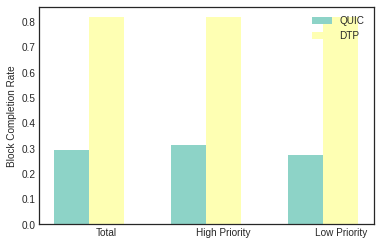

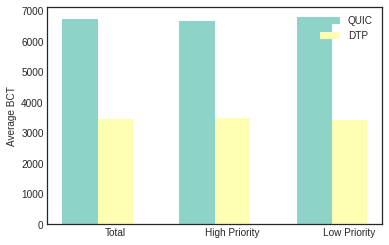

In [16]:
get_stats("data/client_t_n_fifo.csv")
get_stats("data/client_t_t_fifo.csv")
draw_cmp_fig(["data/client_t_n_fifo.csv", "data/client_t_t_fifo.csv"], "data/trace_1300_1ms_1000_seq012.txt", ["QUIC", "DTP"])

In [17]:
get_stats("data/client_n_n_fifo.csv")
get_stats("data/client_n_n.csv")
get_stats("data/client_t_t_fifo.csv")
get_stats("data/client_t_t.csv")

stats of data/client_n_n_fifo.csv
prio  2 6253.49
prio  1 6272.96
throughput: 79.15136283311222
goodput:  24.141165664099226
avg_bct:  6263.225
stats of data/client_n_n.csv
prio  2 4487.272727272727
prio  1 2495.497142857143
throughput: 37.23159170075378
goodput:  37.07710376838551
avg_bct:  3040.9626556016597
stats of data/client_t_t_fifo.csv
prio  1 3468.5
prio  2 3425.816
throughput: 125.96663647666279
goodput:  103.04070863791016
avg_bct:  3447.158
stats of data/client_t_t.csv
prio  2 4305.151515151515
prio  1 2349.066889632107
throughput: 80.46346143753172
goodput:  79.65342659084516
avg_bct:  3323.827181208054


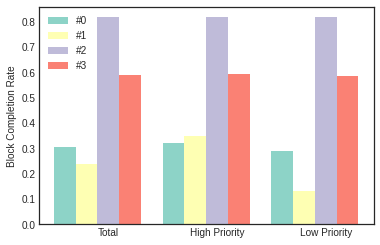

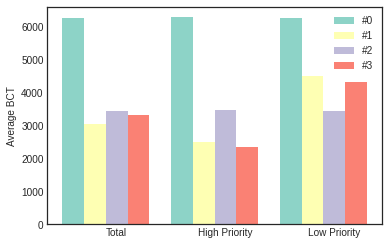

In [20]:
draw_cmp_fig(["data/client_n_n_fifo.csv", "data/client_n_n.csv", "data/client_t_t_fifo.csv", "data/client_t_t.csv"], "data/trace_1300_1ms_1000_seq012.txt")